## Laboratorio: Eliminación de anomalías de la imagen 
#### Grupo 18 Equipo 9: Miembros
Alberto Rodríguez Álvarez  
Andrés Molares Ulloa  
Mario García Mayo  
Xavier Castilla Carbonell

#### Descripción del problema
Buscamos solucionar una sobreexposición localizada de una foto también conocida como "Blowout", normalmente generada por un foco de luz demasiado intenso.

#### Solución planteada
Como se ha visto en clase, el uso de funciones como la exponencial aplicadas sobre el histograma de una imagen son usadas para corregir la sobreexposición generalizada de una imagen. En nuestro caso concreto, al buscar la corrección de un artefacto mucho más localizado planteamos la idea de aplicar este tipo de funciones a una región concreta de la imagen (aquella con una mayor sobreexposición) y conservar los valores del resto de la imagen, evitando así su oscurecimiento. Para ello hemos codificado 4 funciones que aplican ditintas tranformaciones con el fin de encontrar la mejor solución: una combinación de dos rectas de diferente pendiente, la función exponencial, la función logarítmica (con valores negativos) y por última la combinación de la función identidad con una función exponencial.

#### Desarrollo del ejecicio

##### 1 Módulos
Carga de los modulos usados durante la práctica.

##### 2 Carga imagen y visualización
En este apartado se procede a la carga, procesado básico (paso a formato hsv) y visualización de las imágenes que posteriormente serán usadas como ejemplo.

##### 3 Visualización zonas afectadas
En este apartado se muestra para ejemplo la parte de la imagen con sobreexposición.

##### 4 Kernels
En este apartado se definen las funciones de corrección aplicadas como solución a la actividad.

##### 5 Visualizar kernels
En este apartado se pueden observar una representación gráfica de las funciones definidas en el apartado anterior

##### 6 Función de transformación
En este apartado se definde la función que aplica los kernels a la parte afectada de la imagen a tratar.

##### 7 Definición y visualización de ejemplos
En este apartado se muestran las imagenes de ejemplo con las distintas funciones de corrección aplicadas. Para cada imagen se buscaron y aplicaron los parámetros que ofrecían un mejor resultado.

##### 8 Conclusiones
Por último se recogen las conclusiones extraídas durante la realización de la práctica.

## Módulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

## Carga imagen y visualización

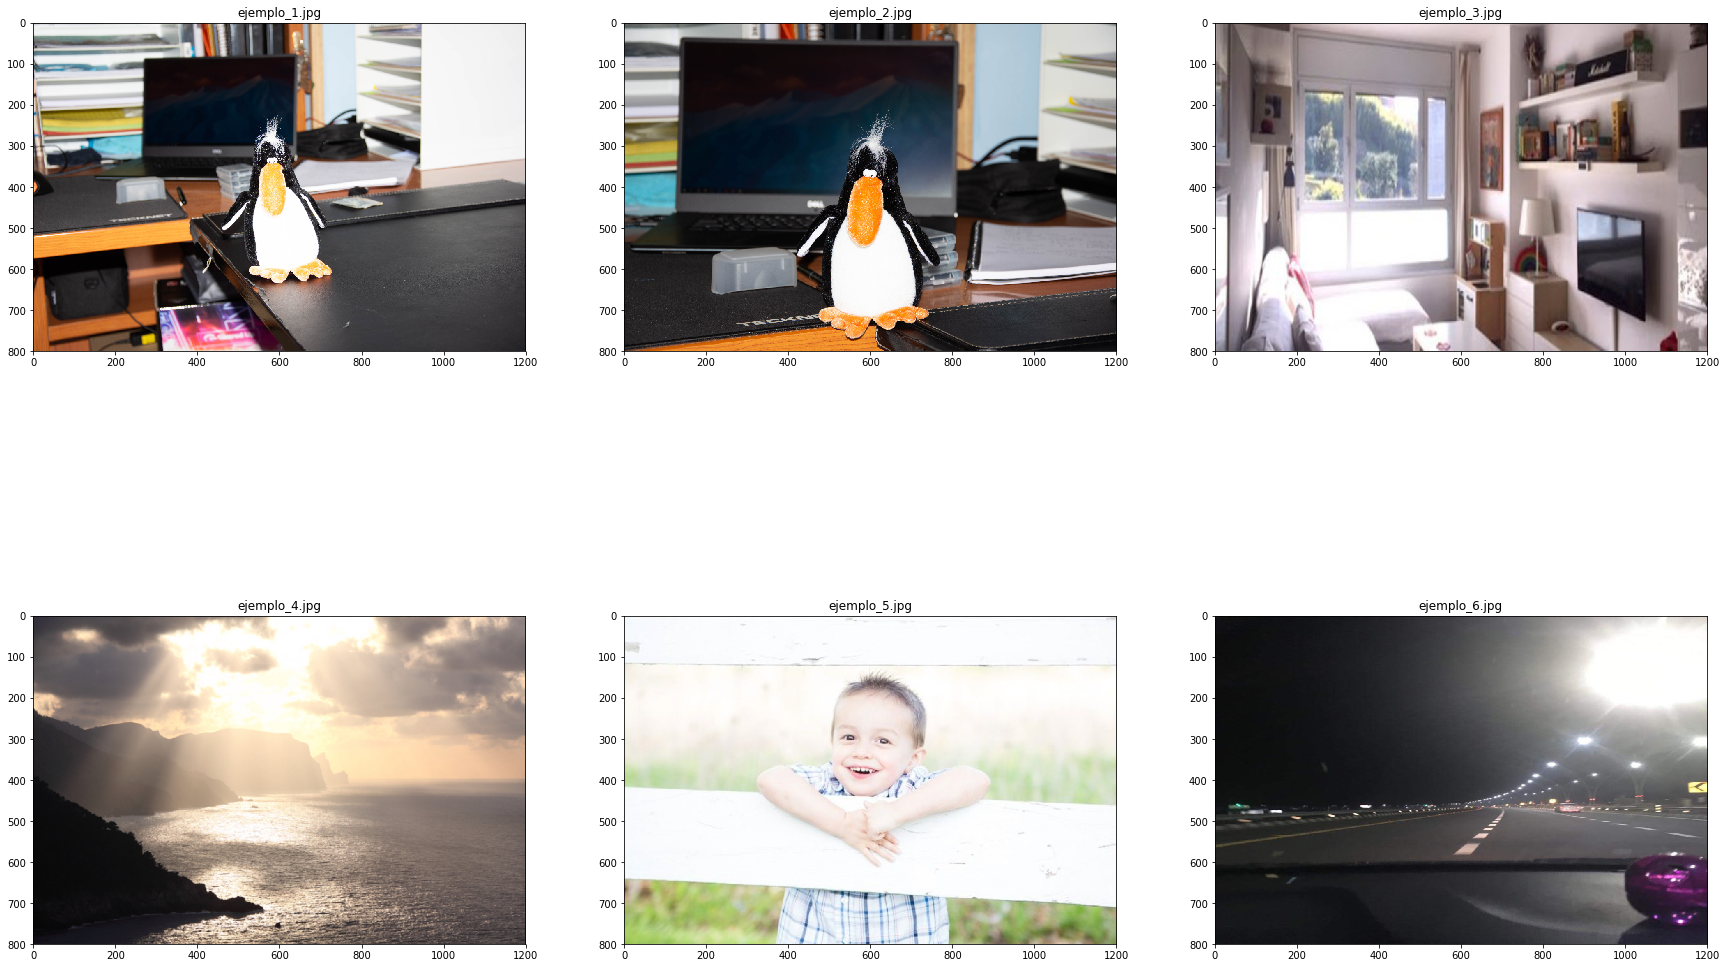

In [23]:
Imgfile1='images/ejemplo_1.jpg'
Imgfile2='images/ejemplo_2.jpg'
Imgfile3='images/ejemplo_3.jpg'
Imgfile4='images/ejemplo_4.jpg'
Imgfile5='images/ejemplo_5.jpg'
Imgfile6='images/ejemplo_6.jpg'
lista = [Imgfile1, Imgfile2, Imgfile3, Imgfile4, Imgfile5, Imgfile6]


def norm_hsv(img):
    """
    Normaliza una imagen HSV. La pasa el canal del brillo de 0-255 en np.uint8 a 0-1 en float
    """
    out=np.copy(img.astype(float))
    out[:,:,2]=img[:,:,2]/255
    return out
def denorm_hsv(img):
    """
    Operazion inversa a norm_hsv(). Devulve la imagen HSV en np.uint8 con H de 0-179 S de 0-255 y V de 0-255 (formato estandar de cv2)
    """
    out=np.copy(img)
    out[:,:,2]=img[:,:,2]*255
    return out.astype(np.uint8)

def load_img(file,resize=(1200,800),show=True):
    """
    Carga la imagen suministrada (path) y devuelve la imagen en HSV normalizada (brillo de 0 a 1). Se muestra la imagen al cargarla
    """

    img=cv2.imread(file,cv2.IMREAD_COLOR)  #Cargar imagen (lo hace en BGR)
    
    if resize==False:
        pass
    else:
        img=cv2.resize(img,resize)           #Reducir el tamaño si la imagen es grande
        
    HSVimg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    if show:
        fig, axs = plt.subplots(figsize=(10,10))
        plt.imshow(cv2.cvtColor(HSVimg,cv2.COLOR_HSV2RGB))
    
    return norm_hsv(HSVimg)

fig, axs = plt.subplots(2,3,figsize=(30,20))
x=0; y=0
for Imgfile in lista:
    img=load_img(Imgfile,show=False)
    axs[y][x].set_title(Imgfile[7:])
    axs[y][x].imshow(cv2.cvtColor(denorm_hsv(img), cv2.COLOR_HSV2RGB))
    x=x+1
    if x>2:
        x=0; y=1

## Visualización zonas efectadas

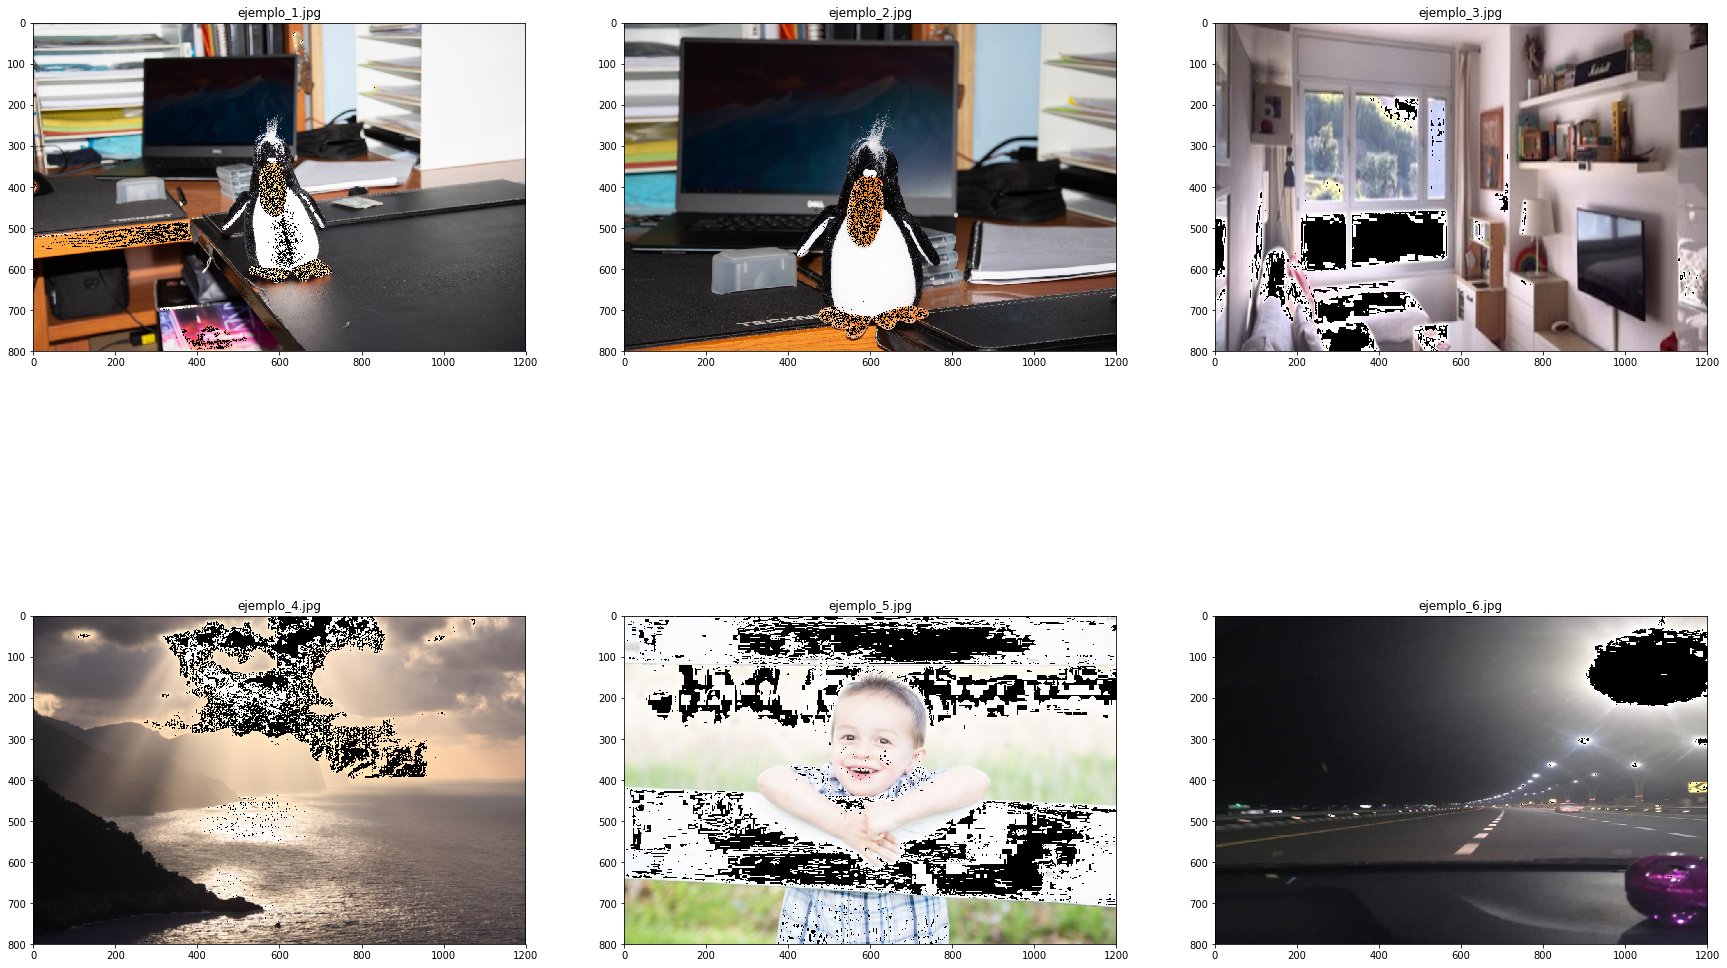

In [22]:
def show_over(img,threshold):
    """
    Muestra la parte de la imagen que se pasa de un cierto porcentaje de intensidad.
    La intensidad va de 0 a 1, por lo que threshold tambien.
    """
    img[:,:,2]=np.where(img[:,:,2]>=threshold, 0, img[:,:,2])
    return img

saturacion = 1 # El valor 1 representa las zonas completamente saturadas y potencialmente irrecuperables

fig, axs = plt.subplots(2,3,figsize=(30,20))
x=0; y=0
for Imgfile in lista:
    img=load_img(Imgfile,show=False)
    img=show_over(img,saturacion) 
    axs[y][x].set_title(Imgfile[7:])
    axs[y][x].imshow(cv2.cvtColor(denorm_hsv(img), cv2.COLOR_HSV2RGB))
    x=x+1
    if x>2:
        x=0; y=1

###  Kernels

In [4]:
def kernel_doble_recta(valor,xc,yc):
    """
    Xc y Yc son las cordenadas del punto donde se unen las rectas.
    """
    if valor<xc:
        m=yc/xc
        out=valor*m
    else:
        m=(yc-1)/(xc-1)
        n=1-m
        out=valor*m+n
    return out

def kernel_exp(valor,alpha,max_r,max_s):
    """
    max_r es el valor maximo de entrada y max_s el de salida. Alpha más alto mayor es el efecto de reducción de brillo.
    """
    c=max_s/((1+alpha)**max_r-1)
    out=c*((1+alpha)**valor-1)
    return out

def kernel_log(valor,alpha,max_r,max_s):
    """
    max_r es el valor maximo de entrada y max_s el de salida. Alpha más alto mayor es el efecto de aumento de brillo.
    """
    c=max_s/np.log(1+(math.exp(alpha)-1)*max_r)
    out=c*np.log(1+(math.exp(alpha)-1)*valor)
    return out
                   
def kernel_exp_recta(valor,alpha,inicio_r,inicio_s,max_r,max_s):
    """
    Similar al kernel exponencial, pero se combina con la transformación identidad
    """
    c=(max_s-inicio_s)/((1+alpha)**(max_r-inicio_r)-1)
    if valor<inicio_r:
        m=inicio_s/inicio_r
        out=valor*m
    else:
        out=c*((1+alpha)**(valor-inicio_r)-1)+inicio_s
    return out

### Visualizar kernels

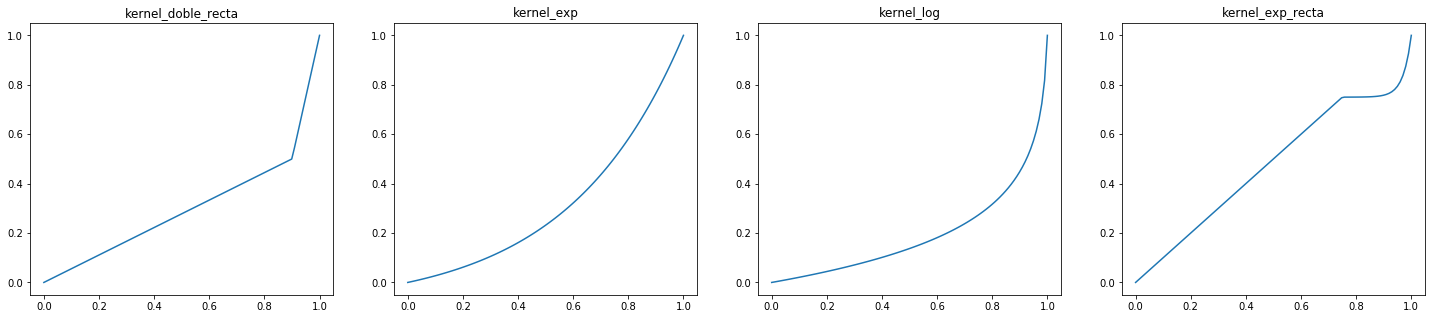

In [17]:
def show_kernel(axs,n,kernel,*args):
    r=np.linspace(0,1,100)
    s=np.array([kernel(i,*args) for i in r])
    axs[n].set_title(kernel.__name__)
    axs[n].plot(r,s)
    
fig, axs = plt.subplots(1,4,figsize=(25,5))
show_kernel(axs,0,kernel_doble_recta,0.9,0.5)
show_kernel(axs,1,kernel_exp,10,1,1)
show_kernel(axs,2,kernel_log,-5,1,1)
show_kernel(axs,3,kernel_exp_recta,1E+15,0.75,0.75,1,1)

### Funcion de transformación

In [6]:
def transform(img,axs,n,kernel,*args,show=True): 
    """
    Se le pasa, la imagen en HSV normalizado, el kernel, los argumentos del kernel en orden, y si quieres que compare el resultado con el oringinal
    """
    nx,ny,nz=img.shape
    out=np.copy(img)
    for x in range(nx):
        for y in range(ny):
            out[x,y,2]=kernel(img[x,y,2],*args) # Aplicacion pixel a pixel de la funcion kernel pasada como parametro
    if show:
        axs[n].set_title(kernel.__name__)
        axs[n].imshow(cv2.cvtColor(denorm_hsv(out), cv2.COLOR_HSV2RGB))
    return out

### Definición y visualización de ejemplos

images/ejemplo_1.jpg
images/ejemplo_2.jpg
images/ejemplo_3.jpg
images/ejemplo_4.jpg
images/ejemplo_5.jpg
images/ejemplo_6.jpg


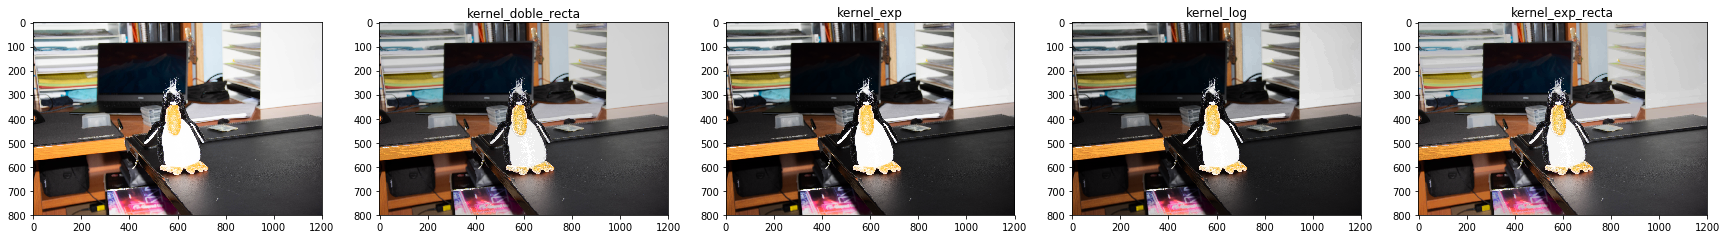

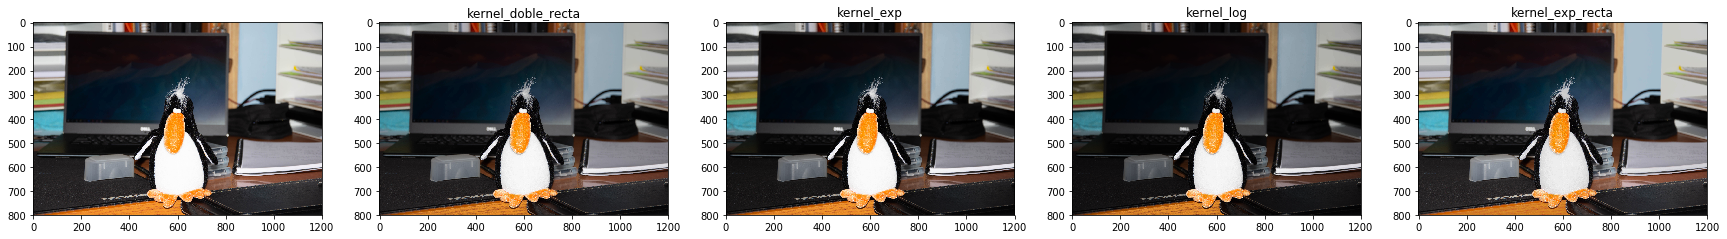

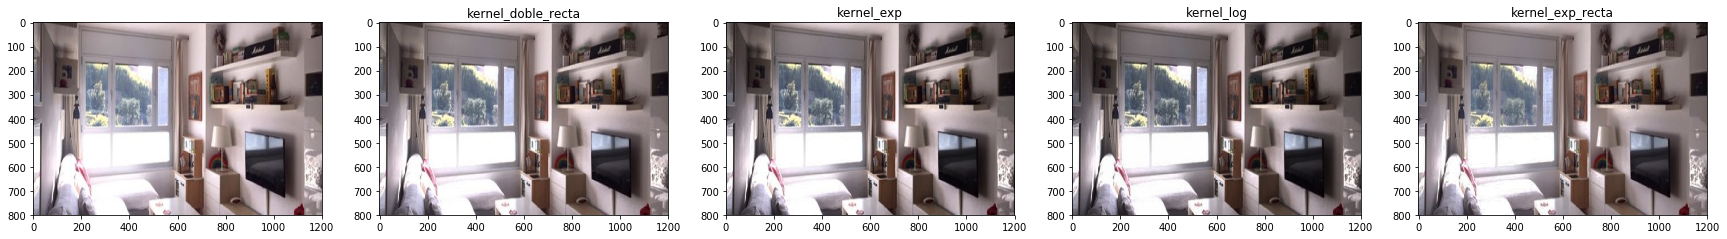

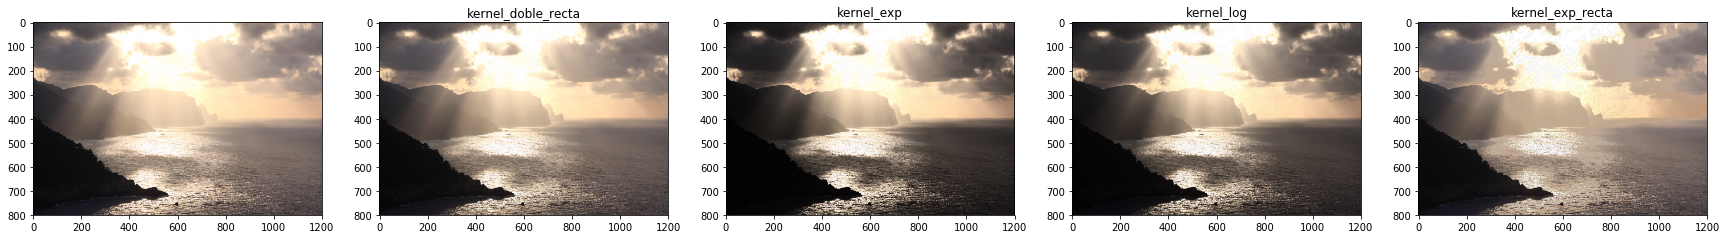

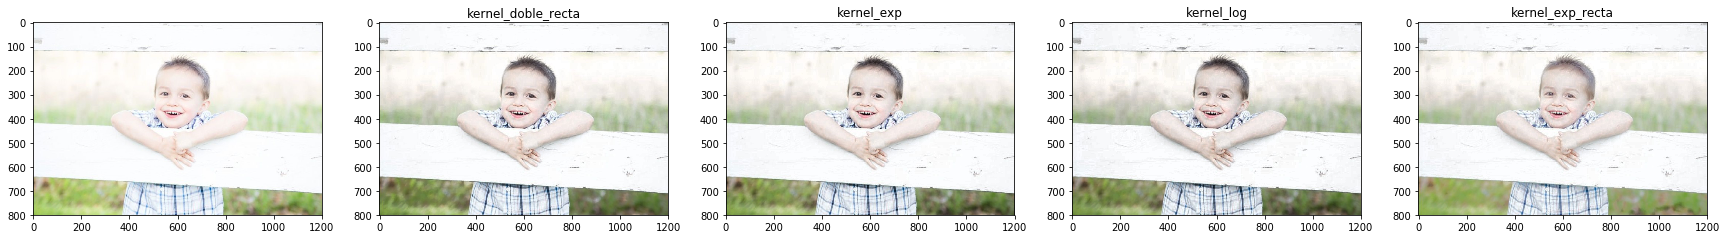

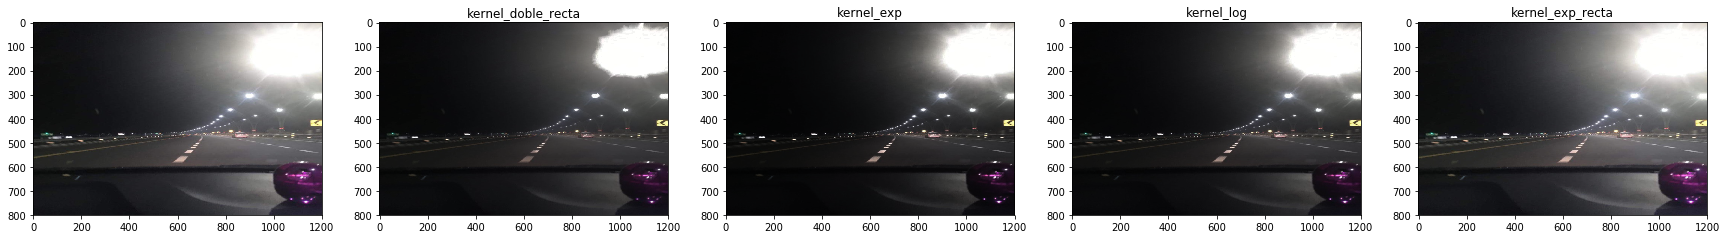

In [7]:
ejemplos = []
ejemplo1 = [Imgfile1, 0.99, 0.85, 4, -2.5, 1E+15, 0.75,0.75]
ejemplo2 = [Imgfile2, 0.9, 0.75, 2, -2, 1E+15, 0.80,0.80]
ejemplo3 = [Imgfile3, 0.65, 0.55, 2, -1.5, 500, 0.65,0.55]
ejemplo4 = [Imgfile4, 0.9, 0.8, 10, -2, 1E+15, 0.75,0.75]
ejemplo5 = [Imgfile5, 0.75, 0.5, 5, -2, 1E+3, 0.6,0.6]
ejemplo6 = [Imgfile6, 0.9, 0.5, 8, -2, 5E+5, 0.9,0.9]
ejemplos.append(ejemplo1); ejemplos.append(ejemplo2); ejemplos.append(ejemplo3); ejemplos.append(ejemplo4); ejemplos.append(ejemplo5) ; ejemplos.append(ejemplo6)

def plot(img, xc, yc, alphaE, alphaL, alphaER, inicioX, inicioY):
    fig, axs = plt.subplots(1,5,figsize=(30,20))
    axs[0].imshow(cv2.cvtColor(denorm_hsv(img), cv2.COLOR_HSV2RGB))
    output=transform(img,axs,1,kernel_doble_recta,xc,yc)
    output=transform(img,axs,2,kernel_exp,alphaE,1,1)
    output=transform(img,axs,3,kernel_log,alphaL,1,1)
    output=transform(img,axs,4,kernel_exp_recta,alphaER,inicioX,inicioY,1,1)


for ejemplo in ejemplos:
    print(ejemplo[0])
    img=load_img(ejemplo[0],show=False)
    plot(img,ejemplo[1], ejemplo[2], ejemplo[3], ejemplo[4], ejemplo[5], ejemplo[6], ejemplo[7])

## Conclusiones

Durante la realización de la práctica se intento aplicar kernels discontinuos con el fin de obtener un mayor rango dinámico en la zona afectada, pero pudimos observar que se generaban anomalias cromáticas a la discontinuidad entre las funciones que hacían inservibles estas soluciones. Por lo que se decidió desechar estas soluciones y únicamente contemplar las variantes continuas.

El principal inconveniente que hemos detectado es que a pesar de que conseguimos recuperar información de las partes sobreexpuestas de las imágenes, es imposible restaurar información de las partes completamente saturadas.

Tras realizar las diversas pruebas podemos concluir que el uso de kernel combinado de la recta más la función exponencial es la solución más interesante, debido a que corrige la sobreexposición localizada sin oscurecer el resto de la imagen, siendo esta la premisa planteada inicialmente.

La creación de una función parametrizada que permite aplicar cualquiera de los kernels y ajustar sus parámetros de manera personalizada dota a esta solución de gran versatilidad al poder ajustarse a cualquier imagen de manera individualizada.